## Install library that exists in colab

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 9.0 MB/s eta 0:00:00


## Import Libraries

In [ ]:
from torchmetrics.classification import MulticlassConfusionMatrix
import unicodedata

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import make_grid
from torchvision import models
import torchvision
import torchvision.transforms as transforms
from PIL import Image

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Define Hyperparameters

In [ ]:
CONFIG = {'seed':42,
          'batch_size':32,
          'epoch':50,
          'num_workers':8,
          'lr':0.001,
          }

## Define seed

In [ ]:
def seed_all(seed):
  np.random.seed(seed)
  # torch.manual_seed(seed)
  # torch.cuda.manual_seed(seed)
  # torch.cuda.manual_seed_all(seed)
  # torch.backends.cudnn.deterministic = True
  # torch.backends.cudnn.benchmark = False
  # torch.backends.cudnn.enabled = False

seed_all(CONFIG['seed'])

## Decide to use GPU or CPU

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# or

if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

## Download Data

In [ ]:
cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)

100%|██████████| 170498071/170498071 [00:03<00:00, 43629957.26it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


## Check Data

In [ ]:
cifar10

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train

## Check shape of *data*

In [ ]:
cifar10.data[0].shape

(32, 32, 3)

## Define function that prints images

In [ ]:
def display_images():
    fig, subplots = plt.subplots(1, 5, figsize=(13, 6))
    for i in range(5):
        axi1 = subplots.flat[i]
        original_img = Image.fromarray(cifar10.data[i])
        axi1.imshow(original_img)
        axi1.set_title('original_img')

## Print images

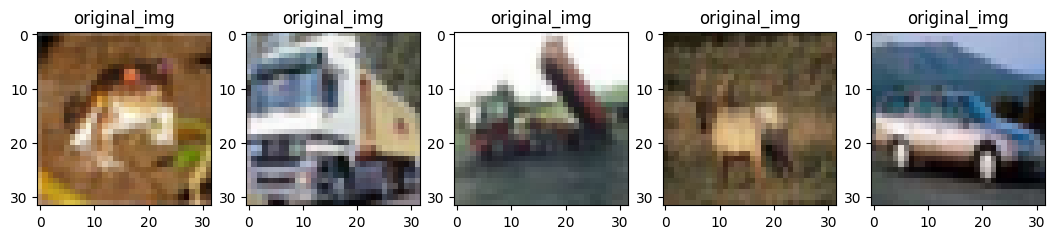

In [ ]:
display_images()

https://pytorch.org/docs/stable/nn.functional.html

## Load data with data augmentation(데이터 변환)

https://pytorch.org/vision/main/transforms.html

In [ ]:
# This mean and std is made by Imagenet
# transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))

train_data_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

val_data_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

traindata = torchvision.datasets.CIFAR10(root='./data',
                                         train=True,
                                         download=False,
                                         transform=train_data_transform)

testdata = torchvision.datasets.CIFAR10(root='./data',
                                        train=False,
                                        download=False,
                                        transform=val_data_transform)


In [ ]:
trainloader = torch.utils.data.DataLoader(traindata, batch_size=CONFIG['batch_size'],
                                          shuffle=True, num_workers=CONFIG['num_workers'])

testloader = torch.utils.data.DataLoader(testdata, batch_size=CONFIG['batch_size'],
                                         shuffle=False, num_workers=CONFIG['num_workers'])

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
classes = traindata.classes

## Define model object

In [ ]:
# class DNN(nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.fc1 = nn.Linear(3 * 32 * 32, 4096)
#     self.fc2 = nn.Linear(4096, 4096)
#     self.fc3 = nn.Linear(4096, 1024)
#     self.fc4 = nn.Linear(1024, 64)
#     self.fc5 = nn.Linear(64, 10)
#     #self.dropout = nn.Dropout(0.5)

#   def forward(self,x):
#     x = torch.flatten(x,1)
#     x = F.relu(self.fc1(x))
#     #x = self.dropout(x)
#     x = F.relu(self.fc2(x))
#     x = F.relu(self.fc3(x))
#     x = F.relu(self.fc4(x))
#     x = self.fc5(x)
#     #x = F.tanh(self.fc1(x))
#     #x = F.sigmoid(self.fc1(x))

#     return x


# net = DNN()

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        #self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))#[batch_size, 3, 36, 36] -> relu([batch_size, 16, 32, 32]) -> [batch_size, 16, 16, 16]
        x = self.pool(F.relu(self.conv2(x)))#[batch_size, 16, 18, 18] -> relu[batch_size, 32, 16, 16] -> [batch_size, 32, 8, 8]
        #x = self.pool(F.relu(self.bn1(self.conv2(x))))
        x = torch.flatten(x, 1) #[batch_size, 32, 8, 8] -> 32 * 8 * 8
        x = F.relu(self.fc1(x))#32 * 8 * 8 -> 120
        x = F.relu(self.fc2(x))#120 -> 84
        x = self.fc3(x)#84 -> 10
        return x


net = Net()

In [ ]:
# class Ensemble(nn.Module, model1, model2, model3):
#   def __init__(self):
#     super().__init__()
#     self.model1 = model1
#     self.model2 = model2
#     self.model3 = model3

#   def forward(self,x):
#     x1 = self.model1(x)
#     x2 = self.model2(x)
#     x3 = self.model3(x)
#     return x1+x2+x3

#net = Emsemble()

## Load resnet

https://pytorch.org/vision/stable/models.html

In [ ]:
# net = models.resnet18(pretrained=True)
# # resnet18, 34, 50, 101, 152
# fc_in_features = net.fc.in_features
# net.fc = nn.Linear(fc_in_features,len(classes))

## Set loss function and optimizer function

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=CONFIG['lr'])#weight_decay=0.001
#optimizer = optim.Adam(net.parameters(),lr=CONFIG['lr'])#weight_decay=0.001
#optimizer = optimAdamW(net.parameters(),lr=CONFIG['lr'])#weight_decay=0.001
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Set learning rate scheduler

In [ ]:
#scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.97 ** epoch)
#scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.0001)
#scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=7, T_mult=1, eta_min=0.00005)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=7, min_lr=0.000001,verbose=True)

In [ ]:
for epoch in tqdm(range(CONFIG['epoch'])):

    running_loss = 0.0
    total = 0
    correct = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images.to(device))
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'epoch : {epoch} \t train_loss : {loss:.4f} \t val_corr : {correct / total:.4f}')
print('Finished Training')

  0%|          | 0/50 [00:00<?, ?it/s]

epoch : 0 	 train_loss : 1.9310 	 val_corr : 0.3274
epoch : 1 	 train_loss : 1.7076 	 val_corr : 0.4118


In [ ]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

temp = [[0]*len(classes)]*len(classes)
temp_tensor = torch.tensor(temp).to(device)
metric = MulticlassConfusionMatrix(len(classes)).to(device)

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images.to(device))
        _, predictions = torch.max(outputs, 1)

        temp_tensor += metric(predictions, labels)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


save = temp_tensor.to('cpu')
metrix = np.array(save)
plt.figure(figsize = (30, 30))
for_heatmap = []
for i in classes:
  for_heatmap.append(unicodedata.normalize('NFC',i))
sns.heatmap(metrix, annot=True, cmap='Blues',fmt='g',xticklabels=for_heatmap,yticklabels=for_heatmap)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Print filters of first layer

In [ ]:
# for w in net.parameters():
#   w = w.data.cpu()
#   print(w.shape)
#   break

# min_w = torch.min(w)
# w1 = (-1/(2 * min_w)) * w + 0.5

# grid_size = len(w1)
# x_grid = [w1[i] for i in range(grid_size)]
# x_grid = make_grid(x_grid, nrow=8, padding=1).permute(1,2,0)

# plt.figure(figsize=(10,10))
# plt.imshow(x_grid)
# plt.show()

In [ ]:
torch.save({'model' : net.state_dict(),
            'optimizer' : optimizer.state_dict()},
            './my_model.pt')